In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import FreqDist
from nltk.util import ngrams
import nltk
from nltk.stem import WordNetLemmatizer 

In [2]:
# Loading all three datasets

calendar = pd.read_csv('calendar.csv', sep=',')
listings = pd.read_csv('listings.csv', sep=',')
reviews = pd.read_csv('reviews.csv', sep=',')

In [4]:
# Checking NaN values in "price" and "neighborhood"

print('The percentage of NaN values in price is: {:.2f} %' 
      .format(100*(calendar['price'].isna().sum()/calendar['price'].shape[0])))
print('The percentage of NaN values in neighbourhood is: {:.2f} %' 
      .format(100*(listings['neighbourhood_cleansed'].isna().sum()/listings['neighbourhood_cleansed'].shape[0])))

The percentage of NaN values in price is: 0.00 %
The percentage of NaN values in neighbourhood is: 0.00 %


In [5]:
# Task to put adjusted price as a workable float.

calendar['adjusted_price'] = calendar['adjusted_price'].str.replace('$', '')
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(',', '')
calendar['adjusted_price'] = calendar['adjusted_price'].astype('float')

In [6]:
print('The percentage of NaN values in price is: {:.2f} %' 
      .format(100*(calendar['adjusted_price'].isna().sum()/calendar['adjusted_price'].shape[0])))
print('The percentage of NaN values in neighbourhood is: {:.2f} %' 
      .format(100*(listings['neighbourhood_cleansed'].isna().sum()/listings['neighbourhood_cleansed'].shape[0])))

The percentage of NaN values in price is: 0.00 %
The percentage of NaN values in neighbourhood is: 0.00 %


(array([120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170.]),
 <a list of 11 Text major ticklabel objects>)

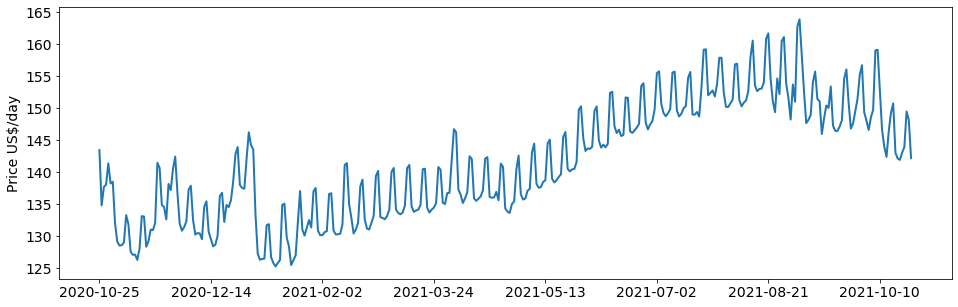

In [8]:
# Plotting raw ask prices

calendar.groupby('date').mean().adjusted_price.plot(figsize=(16,5), linewidth=2, color='tab:blue')
plt.xlabel('')
plt.xticks(fontsize=14)
plt.ylabel('Price US$/day', fontsize=14)
plt.yticks(fontsize=14)

(array([125., 130., 135., 140., 145., 150., 155., 160.]),
 <a list of 8 Text major ticklabel objects>)

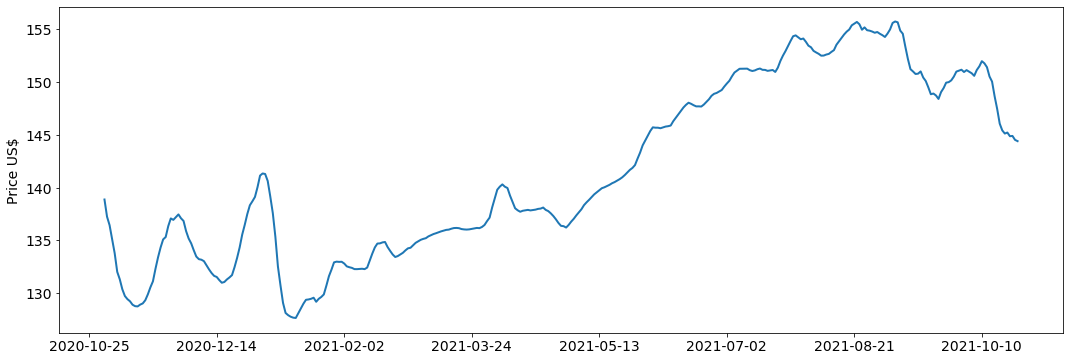

In [9]:
# Plotting seven days moving average in price

hist_prices = calendar.groupby('date').agg({'adjusted_price': 'mean'}).rolling(window = 7).agg({'adjusted_price': ('mean', 'std')})

hist_prices['adjusted_price']['mean'].plot(figsize=(18,6), linewidth=2, color='tab:blue')
plt.xlabel('')
plt.xticks(fontsize=14)
plt.ylabel('Price US$', fontsize=14)
plt.yticks(fontsize=14)

In [13]:
calendar.columns = ['id', 'date', 'availabe', 'price', 'adjusted_price', 'min_nights', 'max_nights']

calendar = pd.merge(calendar, listings[['id', 
                                        'neighbourhood_cleansed', 
                                        'neighbourhood_group_cleansed']], on='id')
calendar.head(2)

,id,date,availabe,price,adjusted_price,min_nights,max_nights,neighbourhood_cleansed,neighbourhood_group_cleansed
0,22153582,2020-10-25,t,$144.00,144.0,3,1125,Pike-Market,Downtown
1,22153582,2020-10-26,t,$141.00,141.0,3,1125,Pike-Market,Downtown


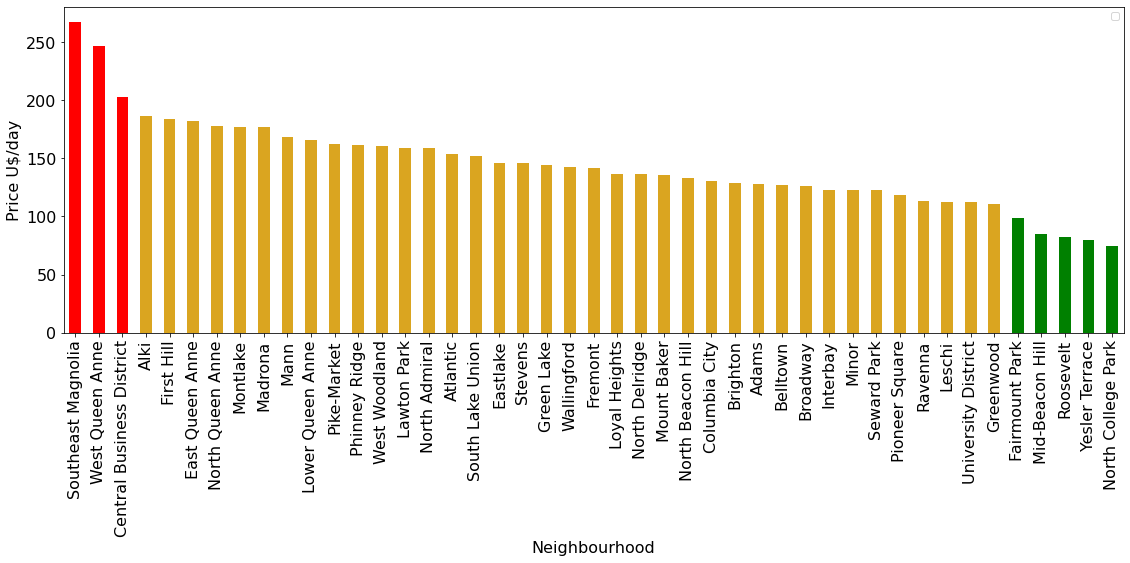

In [14]:
# Filtering neighboorhoods with at least 30 reviews and plotting average price in the whole dataset

count_neigh = listings['neighbourhood_cleansed'].value_counts()
min_count = 30

filtered = list(count_neigh[count_neigh > min_count].index)

cal_filt = calendar['neighbourhood_cleansed'].isin(filtered)

neigh_prices = calendar[cal_filt].groupby('neighbourhood_cleansed').agg({'adjusted_price':
                                                                'mean'}).sort_values(by='adjusted_price', 
                                                                                     ascending=False)



barplot = neigh_prices.plot(kind='bar',figsize=(19,6), color='goldenrod')
barplot.patches[neigh_prices.index.get_indexer(['Southeast Magnolia'])[0]].set_facecolor('r')
barplot.patches[neigh_prices.index.get_indexer(['West Queen Anne'])[0]].set_facecolor('r')
barplot.patches[neigh_prices.index.get_indexer(['Central Business District'])[0]].set_facecolor('r')
barplot.patches[neigh_prices.index.get_indexer(['North College Park'])[0]].set_facecolor('g')
barplot.patches[neigh_prices.index.get_indexer(['Roosevelt'])[0]].set_facecolor('g')
barplot.patches[neigh_prices.index.get_indexer(['Yesler Terrace'])[0]].set_facecolor('g')
barplot.patches[neigh_prices.index.get_indexer(['Mid-Beacon Hill'])[0]].set_facecolor('g')
barplot.patches[neigh_prices.index.get_indexer(['Fairmount Park'])[0]].set_facecolor('g')


fontsize=16

plt.xticks(fontsize=fontsize);
plt.xlabel('Neighbourhood', fontsize=fontsize)
plt.yticks(fontsize=fontsize);
plt.ylabel('Price U$/day', fontsize=fontsize)
plt.legend('')

In [16]:
# Merging neighborhood and reviews in a small list to check in NLTK

small_listings = pd.merge(reviews, listings[['id', 'neighbourhood_cleansed', 'description']], left_on='listing_id', right_on='id').drop(['id_x', 'id_y'], axis=1)
small_listings = small_listings[['neighbourhood_cleansed', 'comments', 'description']]
small_listings.dropna(subset=['neighbourhood_cleansed', 'comments'], axis=0)
small_listings.head()

,neighbourhood_cleansed,comments,description
0,Madrona,1000 times better than staying at a hotel.,"Gorgeous, architect remodeled, Dutch Colonial ..."
1,Madrona,"Our family (two couples, a two year old and an...","Gorgeous, architect remodeled, Dutch Colonial ..."
2,Madrona,Top of the list locations we have stayed at! T...,"Gorgeous, architect remodeled, Dutch Colonial ..."
3,Madrona,"SUCH an awesome place. Very clean, quiet and s...","Gorgeous, architect remodeled, Dutch Colonial ..."
4,Madrona,We flew quite a distance to be at our only dau...,"Gorgeous, architect remodeled, Dutch Colonial ..."


In [17]:
# Selecting stopwords and including some stopwords in the list.

my_stopwords = stopwords.words('english')
my_stopwords.extend(['br', '', 'The', 'for'])

In [18]:
# Counting revies per neighborhood and selecting top 20
# The more reviews, more "real" can be the analysis.

listings_top_20 = small_listings.groupby('neighbourhood_cleansed').agg({'comments': 'count'}).sort_values(by='comments', 
                                                                                        ascending=False).head(20)
listings_top_20

,comments
neighbourhood_cleansed,
Broadway,18320
Belltown,14926
Wallingford,14544
Fremont,14133
Minor,10862
Columbia City,6992
First Hill,6896
Greenwood,6259
North Beacon Hill,6230


In [66]:
# Selecting bigrams "adjective" + "substantive"
# It's gonna take several hours (in my case 6 hours)
# That's why I chose to save that in a pickle file

%%time

import csv
  
lemmatizer = WordNetLemmatizer()

neigh_list = list(listings_top_20.index)
all_bigrams = {}
for neigh in neigh_list:
    bigrams = {}
    bigram = []
    for sentence in small_listings[small_listings['neighbourhood_cleansed'] == neigh].comments:
        try:
            words = nltk.word_tokenize(sentence)
            for i in range(len(words)):
                if nltk.pos_tag(words)[i][1] == 'JJ' and nltk.pos_tag(words)[i+1][1] in ['NN', 'NNS']:
                    adjective = WordNetLemmatizer().lemmatize(words[i], pos='a')
                    noun = WordNetLemmatizer().lemmatize(words[i+1], pos='n')
                    bigram.append((adjective.lower(), noun.lower()))
                    bigrams.update({str(neigh): bigram})
        except:
            None
    all_bigrams.update({str(neigh): bigram})
    print('Updated new neighborhood: {}' .format(neigh))
    neigh = neigh.replace(' ', '_')
    neigh = neigh.replace('-', '')
    neigh = neigh.replace('/', '')
    pd.DataFrame(bigrams).to_csv('bigram_' + str(neigh) + '.csv', sep=',')

Updated new neighborhood: Broadway
Updated new neighborhood: Belltown
Updated new neighborhood: Wallingford
Updated new neighborhood: Fremont
Updated new neighborhood: Minor
Updated new neighborhood: Columbia City
Updated new neighborhood: First Hill
Updated new neighborhood: Greenwood
Updated new neighborhood: North Beacon Hill
Updated new neighborhood: North Admiral
Updated new neighborhood: North Queen Anne
Updated new neighborhood: Adams
Updated new neighborhood: Lower Queen Anne
Updated new neighborhood: Whittier Heights
Updated new neighborhood: Green Lake
Updated new neighborhood: East Queen Anne
Updated new neighborhood: Phinney Ridge
Updated new neighborhood: Stevens
Updated new neighborhood: Mid-Beacon Hill
Updated new neighborhood: Ravenna
CPU times: user 5h 42min 28s, sys: 43.4 s, total: 5h 43min 11s
Wall time: 6h 30min 15s


In [149]:
# Saving the bigram dict in pickle

file_save = open("reviews_bigrams_top20.pkl", "wb")

pickle.dump(all_bigrams, file_save)

file_save.close()

In [19]:
# Reading pickle dict

reviews_bigrams = open("reviews_bigrams.pkl", "rb")

all_bigrams = pickle.load(reviews_bigrams)

In [144]:
# Function to get the top bigrams

def get_top_bigrams(word, how_many, neigh):

    best_bigrams = {}

    for i in range(len(all_bigrams.get(neigh))):
        if word in all_bigrams.get(neigh)[i]:
            bigrama = all_bigrams.get(neigh)[i]
            perc = all_bigrams.get(neigh).count(all_bigrams.get(neigh)[i])/len(all_bigrams.get(neigh))
            best_bigrams.update({bigrama: round(100*perc, 2)})

    best_df = pd.DataFrame(data=best_bigrams.values(), index=best_bigrams.keys(), columns=[str(neigh)])
    #retorno = best_df.T[0].sort_values(ascending=False).head(how_many)
    
    return best_df.sort_values(by=str(neigh), ascending=False).head(how_many)

In [145]:
# Function to get neighborhood list descending frequencies by word.

def neigh_by_noun(word, neighlist):
    
    df = pd.DataFrame()
    
    for neigh in neighlist:
        
        try:
        
            df = pd.concat([df, get_top_bigrams(word, 5, neigh)], axis=1).fillna(0)
        
        except:
        
            None
    
    return df.nlargest(5, df.columns, keep='first')

In [126]:
# This is the neigh list I choose in the problem

neighlist = ['Atlantic', 
'South Lake Union', 
'Eastlake', 
'Stevens', 
'Green Lake', 
'Wallingford', 
'Fremont', 
'Loyal Heights', 
'North Deridge', 
'Mount Baker', 
'North Beacon Hill', 
'Columbia City', 
'Brighton', 
'Adams', 
'Belltown', 
'Broadway', 
'Interbay', 
'Minor', 
'Seward Park', 
'Pioneer Square', 
'Ravenna', 
'Leschi', 
'University District', 
'Greenwood', 
'Fairmount Park', 
'Mid-Beacon Hill', 
'Roosevelt', 
'Yesler Terrace', 
'North College Park']

In [146]:
# Visualizing the bigram by neighborhood in a pandas dataframe

occurrences_dt = neigh_by_noun('neighborhood', neighlist)
occurrences_dt

,,Atlantic,South Lake Union,Eastlake,Stevens,Green Lake,Wallingford,Fremont,Loyal Heights,Mount Baker,North Beacon Hill,...,Pioneer Square,Ravenna,Leschi,University District,Greenwood,Fairmount Park,Mid-Beacon Hill,Roosevelt,Yesler Terrace,North College Park
quiet,neighborhood,0.61,0.21,0.45,1.01,0.62,0.77,0.52,1.37,0.79,0.74,...,0.00,1.22,1.05,0.41,0.85,0.79,0.43,0.58,0.32,0.71
safe,neighborhood,0.23,0.13,0.10,0.00,0.13,0.17,0.11,0.00,0.15,0.14,...,0.00,0.20,0.17,0.07,0.18,0.28,0.13,0.12,0.09,0.30
nice,neighborhood,0.23,0.05,0.21,0.21,0.24,0.28,0.15,0.28,0.27,0.15,...,0.00,0.38,0.25,0.07,0.25,0.24,0.09,0.30,0.09,0.20
residential,neighborhood,0.13,0.00,0.06,0.18,0.00,0.00,0.00,0.19,0.00,0.11,...,0.00,0.20,0.00,0.00,0.15,0.17,0.10,0.12,0.00,0.13
great,neighborhood,0.11,0.21,0.42,0.45,0.41,0.54,0.52,0.67,0.19,0.14,...,0.15,0.43,0.29,0.14,0.32,0.43,0.11,0.23,0.06,0.00


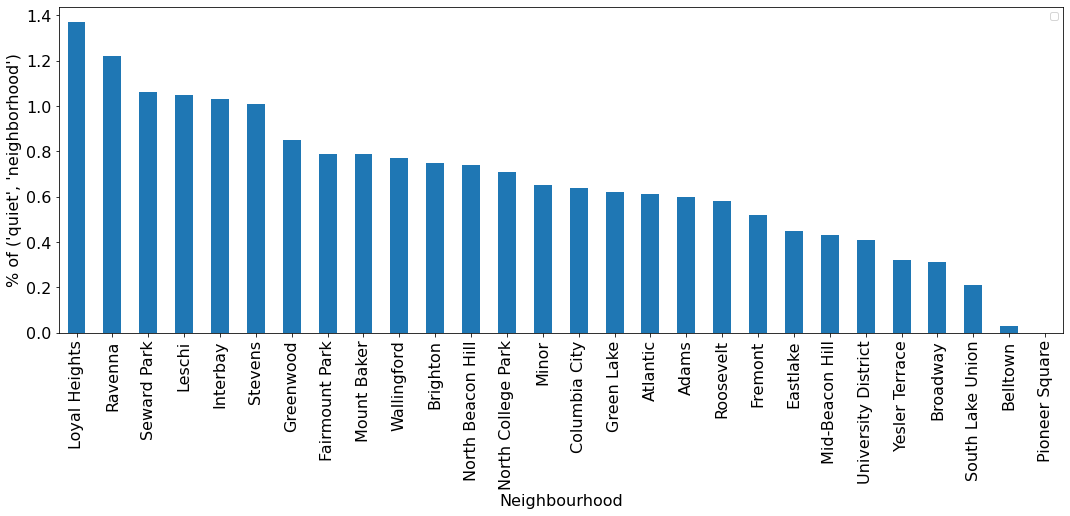

In [149]:
# In bigram_wanted we can change the words to filter whatever we want.

bigram_wanted = ('quiet', 'neighborhood')

occurrences_dt.loc[bigram_wanted].sort_values(ascending=False).plot(kind='bar', figsize=(18,6))

plt.xticks(fontsize=fontsize);
plt.xlabel('Neighbourhood', fontsize=fontsize)
plt.yticks(fontsize=fontsize);
plt.ylabel('% of '+str(bigram_wanted), fontsize=fontsize)
plt.legend('')